In [2]:
# OpenAlex 2024 • Isotope→matching Topic-IDs→Quantum-Search • CSV per (Isotope × Topic) + Combos
# -----------------------------------------------------------------------------------------------
# README (for users):
# - This script queries OpenAlex for works (2023–2025) matching isotope×quantum searches, filtered by Topic-IDs.
# - It writes multiple CSV files per isotope/topic and one combined CSV.
# - To be a good API citizen, identify yourself with a mailto. 
#   Option A (recommended): set an environment variable OPENALEX_MAILTO="your_email@example.com"
#   Option B: replace the placeholder below with your email.
#
# Example output files:
#   - works_2023-2025__Si-28_spin_qubits__T10022.csv
#   - works_2023-2025__C-12_NV-diamond__T10478.csv
#   - works_2023-2025__Yb-171_ion_traps__T11993.csv
#   - works_2023-2025__Sr-87_neutral_atoms_clocks__T12004.csv
#   - works_2023-2025__<ISOTOPE>__ALL_TOPICS.csv
#   - 2023-2025__Quantum_Research__ALL.csv

import os, requests, time, pandas as pd, re
from tqdm import tqdm

BASE = "https://api.openalex.org"

# Replace the placeholder or set OPENALEX_MAILTO in your environment.
# Example (Linux/macOS): export OPENALEX_MAILTO="your_email@example.com"
# Example (Windows PowerShell): $env:OPENALEX_MAILTO="your_email@example.com"
MAILTO = os.getenv("OPENALEX_MAILTO", "YOUR_EMAIL@example.com")

SESSION = requests.Session()
SESSION.headers.update({
    "User-Agent": f"openalex-isotope-notebook/0.1 (+mailto:{MAILTO})"})

# ---- Isotope-specific Topic-IDs (you may extend/modify) ----
ISOTOPE_TOPIC_MAP = {
    # Si-28: Semiconductor quantum (quantum dots/donor/transport)
    "Si-28 (spin qubits)": [
        "https://openalex.org/T10022",  # Semiconductor Quantum Structures and Devices
        "https://openalex.org/T10382",  # Quantum and electron transport phenomena
        "https://openalex.org/T10321",  # Quantum Dots: Synthesis and Properties
    ],
    # C-12: NV/Color-Center/Diamond
    "C-12 (NV-diamond)": [
        "https://openalex.org/T10478",  # Diamond/Color Centers (NV/Carbon-based)
    ],
    # Yb-171: Ion traps / atomic quantum physics (proxy via Atomic/Subatomic)
    "Yb-171 (ion traps)": [
        "https://openalex.org/T11993",  # Atomic and Subatomic Physics Research
    ],
    # Sr-87: Optical clocks / Optical lattice clocks
    "Sr-87 (neutral atoms/clocks)": [
        "https://openalex.org/T12004",  # Advanced Frequency and Time Standards
    ],
}

# ---- Isotope × Quantum search expressions (adjust as needed) ----
ISO_QUERIES = {
    "Si-28 (spin qubits)": (
        '("silicon-28" OR "28Si" OR "Si-28" OR "isotopically enriched silicon" OR "isotopically pure silicon") '
        'AND (qubit OR "spin qubit" OR "quantum dot" OR donor OR quantum)'
    ),
    "C-12 (NV-diamond)": (
        '("carbon-12" OR "12C" OR "isotopically pure diamond" OR "isotopically enriched diamond" OR diamond) '
        'AND ("NV center" OR nitrogen-vacancy OR "color center" OR quantum)'
    ),
    "Yb-171 (ion traps)": (
        '("171Yb" OR "Yb-171") AND ("ion trap" OR "trapped ion" OR ion OR qubit OR quantum)'
    ),
    "Sr-87 (neutral atoms/clocks)": (
        '("87Sr" OR "Sr-87") AND ("optical clock" OR "neutral atom" OR tweezer OR qubit OR quantum)'
    ),
}

def slug(s: str) -> str:
    s = re.sub(r"[^\w\-]+", "_", s.strip())
    s = re.sub(r"_+", "_", s).strip("_")
    return s

def fetch_isoquant_with_topics(topic_id: str, search_expr: str, oa: bool = True,
                               per_page: int = 200, sleep_s: float = 0.25) -> pd.DataFrame:
    """All works 2023–2025 for (Topic-ID ∧ search expression). Cursor-paging with 403-safe mode."""
    rows, cursor = [], "*"
    flt = ["publication_year:2023-2025", "type:article", f"topics.id:{topic_id}"]
    if oa:
        flt.append("open_access.oa_status:gold|hybrid|green|bronze")

    warned = False
    with tqdm(desc=f"Downloading {topic_id.split('/')[-1]}", unit="page") as pbar:
        while cursor:
            params = {
                "filter": ",".join(flt),
                "search": search_expr,
                "per-page": per_page,
                "cursor": cursor,
                "sort": "publication_date:desc",
                "mailto": MAILTO,
                "select": "id,doi,title,publication_year,publication_date,type,cited_by_count,"
                          "open_access.oa_status,primary_location.source.display_name,topics,authorships"
            }
            r = SESSION.get(f"{BASE}/works", params=params, timeout=60)
            if r.status_code == 403:
                if not warned:
                    print("⚠️ 403 – Safe mode (per-page=50, reduced select).")
                    warned = True
                params["per-page"] = 50
                params["select"]   = "id,doi,title,publication_year,publication_date,type"
                r = SESSION.get(f"{BASE}/works", params=params, timeout=60)
            r.raise_for_status()
            data = r.json()
            rows.extend(data.get("results", []))
            cursor = data.get("meta", {}).get("next_cursor")
            pbar.update(1)
            time.sleep(sleep_s)

    # Flatten
    flat = []
    for w in rows:
        insts = []
        for a in (w.get("authorships") or []):
            for ins in (a.get("institutions") or []):
                if ins and ins.get("display_name"):
                    insts.append(ins["display_name"])
        flat.append({
            "id": w.get("id"),
            "doi": w.get("doi"),
            "title": w.get("title"),
            "year": w.get("publication_year"),
            "date": w.get("publication_date"),
            "type": w.get("type"),
            "oa_status": (w.get("open_access") or {}).get("oa_status"),
            "venue": ((w.get("primary_location") or {}).get("source") or {}).get("display_name"),
            "topics": "; ".join([t.get("display_name") for t in (w.get("topics") or []) if t.get("display_name")]) if w.get("topics") else "",
            "institutions": "; ".join(sorted(set(insts))),
            "cited_by": w.get("cited_by_count"),
        })
    df = pd.DataFrame(flat)
    # Dedupe
    df = df.drop_duplicates(subset=(["doi"] if "doi" in df.columns else ["id"])).copy()
    return df


# ---- RUN: per isotope -> iterate over its Topic-IDs -> write CSVs ----
all_isotope_frames = []   # all isotopes together (for overall evaluation)

for iso_label, topic_ids in ISOTOPE_TOPIC_MAP.items():
    iso_query = ISO_QUERIES[iso_label]
    print(f"\n=== ISOTOPE: {iso_label} ===")
    per_iso_frames = []   # accumulated per isotope

    for tid in topic_ids:
        print(f">>> Topic {tid}")
        df = fetch_isoquant_with_topics(tid, iso_query, oa=True, per_page=200)
        df["isotope_group"] = iso_label
        df["topic_id"] = tid
        out_iso_topic = f"works_2023-2025__{slug(iso_label)}__{tid.split('/')[-1]}.csv"
        df.to_csv(out_iso_topic, index=False)
        print(f"Saved: {out_iso_topic} | rows: {len(df)}")
        per_iso_frames.append(df)
        time.sleep(5)  # short pause per (Iso×Topic) run

    # Combined per isotope
    if per_iso_frames:
        df_iso = pd.concat(per_iso_frames, ignore_index=True).drop_duplicates(subset=["doi","id"])
        out_iso = f"works_2023-2025__{slug(iso_label)}__ALL_TOPICS.csv"
        df_iso.to_csv(out_iso, index=False)
        print(f"[Isotope combined] {out_iso} | rows: {len(df_iso)}")
        all_isotope_frames.append(df_iso)

    print("Wait 60 seconds before the next isotope…")
    time.sleep(60)


# Overall (all isotopes)
if all_isotope_frames:
    df_all = pd.concat(all_isotope_frames, ignore_index=True).drop_duplicates(subset=["doi","id"])
    df_all.to_csv("2023-2025__Quantum_Research__ALL.csv", index=False)
    print("\n[ALL] 2023-2025__Quantum_Research__ALL.csv | rows:", len(df_all))



=== ISOTOPE: Si-28 (spin qubits) ===
>>> Topic https://openalex.org/T10022


⚠️ 403 – Safe mode (per-page=50, reduced select).


Saved: works_2023-2025__Si-28_spin_qubits__T10022.csv | rows: 13
>>> Topic https://openalex.org/T10382


⚠️ 403 – Safe mode (per-page=50, reduced select).


Saved: works_2023-2025__Si-28_spin_qubits__T10382.csv | rows: 29
>>> Topic https://openalex.org/T10321


⚠️ 403 – Safe mode (per-page=50, reduced select).


Saved: works_2023-2025__Si-28_spin_qubits__T10321.csv | rows: 2
[Isotope combined] works_2023-2025__Si-28_spin_qubits__ALL_TOPICS.csv | rows: 34
Wait 60 seconds before the next isotope…

=== ISOTOPE: C-12 (NV-diamond) ===
>>> Topic https://openalex.org/T10478


⚠️ 403 – Safe mode (per-page=50, reduced select).


Saved: works_2023-2025__C-12_NV-diamond__T10478.csv | rows: 964
[Isotope combined] works_2023-2025__C-12_NV-diamond__ALL_TOPICS.csv | rows: 964
Wait 60 seconds before the next isotope…

=== ISOTOPE: Yb-171 (ion traps) ===
>>> Topic https://openalex.org/T11993


⚠️ 403 – Safe mode (per-page=50, reduced select).


Saved: works_2023-2025__Yb-171_ion_traps__T11993.csv | rows: 6
[Isotope combined] works_2023-2025__Yb-171_ion_traps__ALL_TOPICS.csv | rows: 6
Wait 60 seconds before the next isotope…

=== ISOTOPE: Sr-87 (neutral atoms/clocks) ===
>>> Topic https://openalex.org/T12004


⚠️ 403 – Safe mode (per-page=50, reduced select).


Saved: works_2023-2025__Sr-87_neutral_atoms_clocks__T12004.csv | rows: 4
[Isotope combined] works_2023-2025__Sr-87_neutral_atoms_clocks__ALL_TOPICS.csv | rows: 4
Wait 60 seconds before the next isotope…

[ALL] 2023-2025__Quantum_Research__ALL.csv | rows: 1008


Input: 1008
Batch 0..39 ✓  (40 classified)
Batch 40..79 ✓  (40 classified)
Batch 80..119 ✓  (40 classified)
Batch 120..159 ✓  (40 classified)
Batch 160..199 ✓  (40 classified)
Batch 200..239 ✓  (40 classified)
Batch 240..279 ✓  (40 classified)
Batch 280..319 ✓  (40 classified)
Batch 320..359 ✓  (40 classified)
Batch 360..399 ✓  (40 classified)
Batch 400..439 ✓  (40 classified)
Batch 440..479 ✓  (40 classified)
Batch 480..519 ✓  (40 classified)
Batch 520..559 ✓  (40 classified)
Batch 560..599 ✓  (40 classified)
Batch 600..639 ✓  (40 classified)
Batch 640..679 ✓  (40 classified)
Batch 680..719 ✓  (40 classified)
Batch 720..759 ✓  (40 classified)
Batch 760..799 ✓  (40 classified)
Batch 800..839 ✓  (40 classified)
Batch 840..879 ✓  (40 classified)
Batch 880..919 ✓  (40 classified)
Batch 920..959 ✓  (40 classified)
Batch 960..999 ✓  (40 classified)
Batch 1000..1007 ✓  (8 classified)
Expected: 1008 | Got: 1008 | Missing: 0
After LLM filter: 595 works
Saved: works_2023-2025__Quanten_Research_

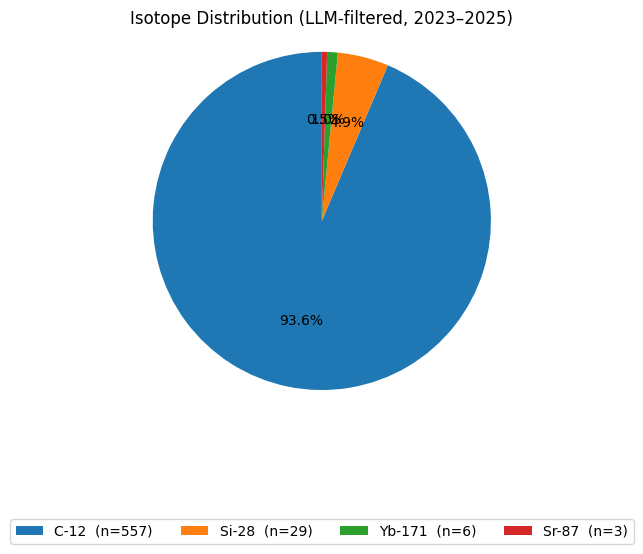

Saved: pie_isotopes_2023-2025_filtered.png


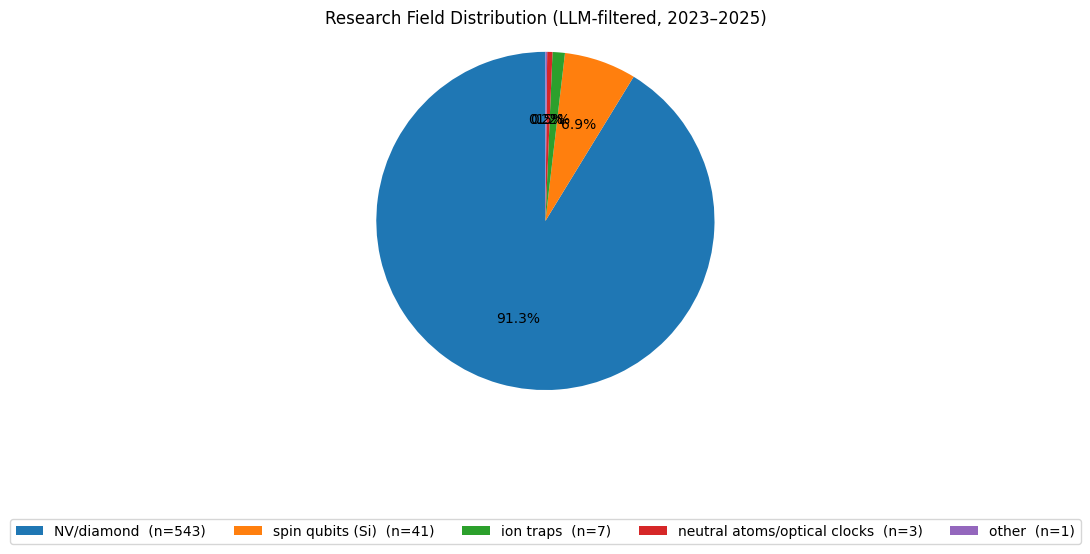

Saved: pie_fields_2023-2025_filtered.png


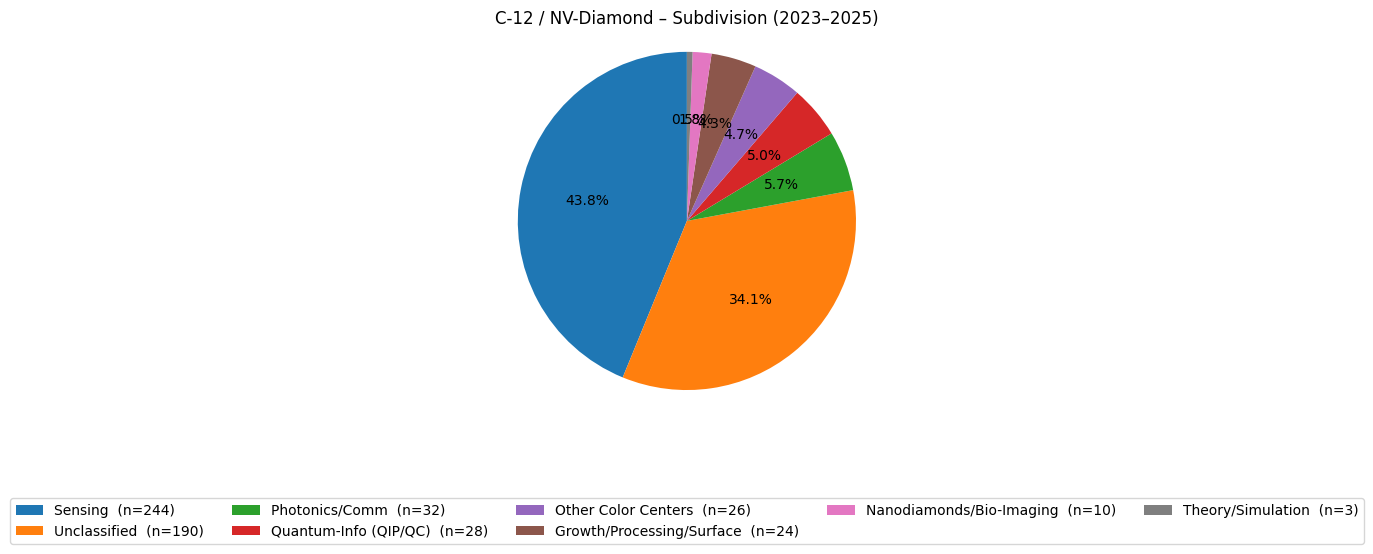

Saved: pie_nvdiamond_buckets_2023-2025.png


In [1]:
# === LLM-Filter + Charts for 2023–2025 Big-Four Isotopes × Quantum ===
# --------------------------------------------------------------------------------
# README for users:
# - This script filters and buckets publications using an LLM and produces charts.
# - You MUST provide an OpenAI API key via environment variable OPENAI_API_KEY.
#   Example (Linux/macOS): export OPENAI_API_KEY="your_key_here"
#   Example (Windows PowerShell): $env:OPENAI_API_KEY="your_key_here"
# - INPUT CSV must exist and contain columns like: title, abstract (optional), topics, venue,
#   isotope_group, topic_id. Missing columns are auto-filled with empty strings.
#
# Example outputs:
#   - works_2023-2025__Quanten_Research__LLM_FILTERED.csv
#   - pie_isotopes_2023-2025_filtered.png
#   - pie_fields_2023-2025_filtered.png
#   - pie_nvdiamond_buckets_2023-2025.png

# pip install openai pandas matplotlib tenacity

import os, json, re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tenacity import retry, wait_exponential_jitter, stop_after_attempt
from openai import OpenAI

# ---- Parameters ----
INPUT_CSV  = "works_2023-2025__Quanten_Research__ALL.csv"     # <- keep this name
OUTPUT_CSV = "works_2023-2025__Quanten_Research__LLM_FILTERED.csv"  # <- keep this name
MODEL      = os.getenv("OPENAI_MODEL", "gpt-4o-mini")  # users may override via env
BATCH_SIZE = 40               # 30–60 is usually the sweet spot
TEMPERATURE= 0.0

# ---- Load & prepare data ----
df = pd.read_csv(INPUT_CSV)
for col in ["title","abstract","topics","venue","isotope_group","topic_id"]:
    if col not in df.columns: df[col] = ""
    df[col] = df[col].fillna("").astype(str)
df = df.reset_index(drop=False).rename(columns={"index":"__rowid__"})
df["__rowid__"] = pd.to_numeric(df["__rowid__"], errors="raise").astype("Int64")

print("Input:", len(df))

# ---- System & instructions for structured classification ----
SYSTEM_MSG = (
    "You are a strict scientific reviewer. "
    "Decide for each entry whether it is RELEVANT to 'Isotopes in connection with quantum technology'. "
    "Focus mainly on: 28Si/Si-28 (spin/donor qubits), 12C (diamond/NV/color centers), "
    "171Yb (ion traps), 87Sr (optical clocks/neutral atoms). "
    "Ignore biomedicine, general chemistry, photonics/lasers without quantum/isotope relevance. "
    "Return ONLY JSON. Each result MUST contain the 'idx' (from input)."
)

USER_TEMPLATE = """Classify the following publications. Return ONLY JSON.

Allow only these values:
- relevant: true|false
- isotope_group: one of ["Si-28","C-12","Yb-171","Sr-87","other/unknown"]
- field_bucket: one of ["NV/diamond","spin qubits (Si)","ion traps","neutral atoms/optical clocks","other"]
- confidence: integer 1..5
- reason: short justification (max 18 words)

Answer format: { "results": [ { "idx": <int>, "relevant": <bool>, "isotope_group": <str>, "field_bucket": <str>, "confidence": <int>, "reason": <str> } , ... ] }

Entries:
{items}
"""

def make_item(row):
    return {
        "idx": int(row["__rowid__"]),
        "title": row["title"][:300],
        "abstract": row.get("abstract","")[:800],
        "topics": row.get("topics","")[:200],
        "venue": row.get("venue","")[:100],
        "seed_isotope_group": row.get("isotope_group","")
    }

# ---- OpenAI Client (user must supply key via env; do NOT hardcode) ----
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise RuntimeError(
        "OPENAI_API_KEY is missing. Set it in your environment. "
       )
client = OpenAI(api_key=api_key)

@retry(wait=wait_exponential_jitter(initial=1, max=20), stop=stop_after_attempt(5))
def classify_batch(rows_batch: pd.DataFrame):
    items = [ make_item(r) for _, r in rows_batch.iterrows() ]
    user_msg = USER_TEMPLATE.replace("{items}", json.dumps(items, ensure_ascii=False))

    resp = client.chat.completions.create(
        model=MODEL,
        temperature=TEMPERATURE,
        messages=[
            {"role":"system", "content": SYSTEM_MSG},
            {"role":"user",   "content": user_msg},
        ],
        response_format={ "type": "json_object" }
    )
    txt = resp.choices[0].message.content

    data = json.loads(txt)
    if isinstance(data, dict) and "results" in data and isinstance(data["results"], list):
        data = data["results"]
    elif isinstance(data, list):
        pass
    else:
        raise ValueError("Response is neither JSON list nor object with 'results'.")

    out = []
    for obj in data:
        out.append({
            "idx": obj.get("idx", None),
            "relevant": bool(obj.get("relevant", False)),
            "isotope_group_llm": obj.get("isotope_group","other/unknown"),
            "field_bucket": obj.get("field_bucket","other"),
            "confidence": int(obj.get("confidence", 3)),
            "reason": str(obj.get("reason",""))[:120],
        })

    missing_idx_pos = [i for i,o in enumerate(out) if o["idx"] is None]
    if missing_idx_pos:
        inp_ids = rows_batch["__rowid__"].tolist()
        if len(inp_ids) != len(out):
            raise ValueError("Length mismatch in idx fallback.")
        for i in missing_idx_pos:
            out[i]["idx"] = int(inp_ids[i])

    for o in out:
        o["idx"] = int(o["idx"])

    return out

# ---- Classify in batches ----
results = []
for start in range(0, len(df), BATCH_SIZE):
    chunk = df.iloc[start:start+BATCH_SIZE]
    out = classify_batch(chunk)
    results.extend(out)
    print(f"Batch {start}..{start+len(chunk)-1} ✓  ({len(out)} classified)")

# ---- Merge results + check coverage ----
res_df = pd.DataFrame(results)
res_df["idx"] = pd.to_numeric(res_df["idx"], errors="raise").astype("Int64")

expected = set(df["__rowid__"].tolist())
got      = set(res_df["idx"].dropna().tolist())
missing  = sorted(expected - got)
print(f"Expected: {len(expected)} | Got: {len(got)} | Missing: {len(missing)}")

if missing:
    retry_chunk = df[df["__rowid__"].isin(missing)]
    retry_out = classify_batch(retry_chunk)
    res_df = pd.concat([res_df, pd.DataFrame(retry_out)], ignore_index=True).drop_duplicates(subset=["idx"])
    got      = set(res_df["idx"].dropna().tolist())
    missing  = sorted(expected - got)
    print(f"After retry missing: {len(missing)}")

merged = df.merge(res_df, left_on="__rowid__", right_on="idx", how="left")

# ---- Final filter (relevant & at least medium confidence) ----
def pick_iso(row):
    v = (row.get("isotope_group_llm") or "").strip()
    if v in ["Si-28","C-12","Yb-171","Sr-87"]:
        return v
    seed = (row.get("isotope_group") or "")
    if "Si-28" in seed: return "Si-28"
    if "C-12"  in seed: return "C-12"
    if "Yb-171" in seed:return "Yb-171"
    if "Sr-87" in seed: return "Sr-87"
    return "other/unknown"

filtered = merged[(merged["relevant"] == True) & (merged["confidence"] >= 3)].copy()
filtered["isotope_final"] = filtered.apply(pick_iso, axis=1)
filtered["field_bucket"]  = filtered["field_bucket"].fillna("other")

print("After LLM filter:", len(filtered), "works")

# ==============================
# NV-Diamond: fine-grained subdivision
# ==============================
NV_BUCKETS = [
    ("Sensing", [
        r"\bnv\b", r"nitrogen[-\s]?vacancy", r"magnetometr", r"magnetometer",
        r"thermometr", r"temperature sensing", r"electrometr", r"\bnmr\b", r"gyroscop",
        r"biosens", r"biomagnet", r"spin noise", r"vector magnet"
    ]),
    ("Quantum-Info (QIP/QC)", [
        r"\bqubit\b", r"spin qubit", r"gate", r"entangl", r"two[-\s]?qubit",
        r"error correction", r"\bt2\b", r"dephasing", r"coherence time", r"rabi"
    ]),
    ("Photonics/Comm", [
        r"single[-\s]?photon", r"indistinguishable", r"cavit(y|ies)", r"purcell",
        r"waveguide", r"grating", r"on[-\s]?chip", r"photonic", r"microring", r"resonator"
    ]),
    ("Growth/Processing/Surface", [
        r"\bcvd\b", r"\bhpht\b", r"isotopic(ally)? (pure|enrich)", r"implant",
        r"anneal", r"delta[-\s]?doping", r"surface termination", r"oxygen[-\s]?termination",
        r"nitrogen implantation", r"etch(ing)?", r"microfabrication"
    ]),
    ("Nanodiamonds/Bio-Imaging", [
        r"nanodiamond", r"nanodiamonds", r"bioimaging", r"\bcell(s)?\b", r"drug delivery",
        r"fluorescen(t|ce) imaging", r"in vivo", r"bio[-\s]?compat"
    ]),
    ("Other Color Centers", [
        r"\bsiv\b", r"silicon[-\s]?vacancy", r"\bgev\b", r"germanium[-\s]?vacancy",
        r"\bsnv\b", r"tin[-\s]?vacancy", r"xev\b", r"vacancy center(s)?", r"divacancy"
    ]),
    ("Theory/Simulation", [
        r"\bab initio\b", r"\bdf?t\b", r"density functional", r"first[-\s]?principles",
        r"spin hamiltonian", r"noise spectroscopy", r"master equation", r"cluster expansion"
    ]),
]

def nv_assign_buckets(title: str, abstract: str) -> list[str]:
    txt = f"{title or ''} {abstract or ''}".lower()
    tags = []
    for bucket, patterns in NV_BUCKETS:
        if any(re.search(p, txt) for p in patterns):
            tags.append(bucket)
    return tags or ["Unclassified"]

def nv_primary_bucket(tags: list[str]) -> str:
    prio = [
        "Sensing", "Quantum-Info (QIP/QC)", "Photonics/Comm",
        "Growth/Processing/Surface", "Nanodiamonds/Bio-Imaging",
        "Other Color Centers", "Theory/Simulation", "Unclassified"
    ]
    for p in prio:
        if p in tags:
            return p
    return "Unclassified"

# apply only for C-12 / NV-Diamond
mask_nv = (filtered["isotope_final"] == "C-12") | (filtered["field_bucket"].str.contains("NV/diamond", case=False, na=False))
if mask_nv.any():
    tmp = filtered.loc[mask_nv].copy()
    tags = tmp.apply(lambda r: nv_assign_buckets(r.get("title"), r.get("abstract")), axis=1)
    filtered.loc[mask_nv, "nv_tags"] = tags
    filtered.loc[mask_nv, "nv_primary"] = filtered.loc[mask_nv, "nv_tags"].apply(nv_primary_bucket)
else:
    filtered["nv_tags"] = None
    filtered["nv_primary"] = None

# ---- Save ----
filtered_out = filtered.drop(columns=["__rowid__","idx"])
filtered_out.to_csv(OUTPUT_CSV, index=False)
print("Saved:", OUTPUT_CSV)

# ---- Charts (no style/colors set; safe for headless runs) ----
def plot_pie_with_legend(series: pd.Series, title: str, outfile: Path):
    counts = series.value_counts().sort_values(ascending=False)
    counts = counts[counts > 0]
    if counts.empty:
        print(f"No data for: {title}")
        return

    fig = plt.figure(figsize=(7, 6))
    ax  = fig.add_axes([0.12, 0.26, 0.76, 0.62])

    wedges, texts, autotexts = ax.pie(
        counts.values,
        labels=None,
        autopct="%1.1f%%",
        startangle=90
    )
    ax.set_title(title, pad=8)
    ax.axis("equal")

    legend_labels = [f"{lab}  (n={val})" for lab, val in counts.items()]
    fig.legend(
        wedges, legend_labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.02),
        fancybox=True,
        ncol=min(len(legend_labels), 5)
    )

    fig.savefig(outfile, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved: {outfile}")

# --- 1) Isotopes (LLM-filtered) ---
plot_pie_with_legend(
    filtered["isotope_final"],
    "Isotope Distribution (LLM-filtered, 2023–2025)",
    Path("pie_isotopes_2023-2025_filtered.png")
)

# --- 2) Research Fields (LLM-filtered) ---
plot_pie_with_legend(
    filtered["field_bucket"],
    "Research Field Distribution (LLM-filtered, 2023–2025)",
    Path("pie_fields_2023-2025_filtered.png")
)

# --- 3) NV-Diamond Subdivision (only C-12) ---
if "nv_primary" in filtered.columns and filtered["nv_primary"].notna().any():
    plot_pie_with_legend(
        filtered.loc[filtered["isotope_final"]=="C-12","nv_primary"],
        "C-12 / NV-Diamond – Subdivision (2023–2025)",
        Path("pie_nvdiamond_buckets_2023-2025.png")
    )
